# Trajectory Reconstruction

The robustness of the proposed approach is evaluated against adversarial attacks by simulating the reconstruction of real trajectories from the published synthetic trajectories using the same model, by computing the Reconstruction Error (RE).

More details can be found in the research paper.


##### **Imports**

In [1]:
import os
# oneDNN warning suppression TF 2.4.1
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import copy

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tilemapbase
import statistics
import math

from typing import List, Tuple

import keras
import tensorflow as tf
from keras import Sequential

from utils.data import *
from utils.plots import *
from utils.metrics import *
from models import *
from apu_trajgen import *

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## **Experiments (Porto dataset)**

In [8]:
selected_dataset = "PORTO"
# The mde_k distances are computed in the trajgen-fixed-k.py script
# They represent the MDE for k=1, k=2, k=3, and k=4 (computed for 5000 trajectories)
# These values are used to determine the adaptive k values based on the privacy and utility constraints
mde_k = [76, 257, 3585, 7185] # mean distances for k=1, k=2, k=3, and k=4

mean_min = [80, 170, 250, 350] # privacy contraint
mean_max = [155, 350, 450, 550] # utility contraint

#### **Load Model and Test Data** 

In [9]:
# Load the test data 
X_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_X_test.pkl") # the input trajectory data
Y_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_test.pkl") # the test trajectory data
test_seq_len = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_seq_len_test.pkl") # the sequence lenght of the input trajectory data
normalization_ranges = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_normalization_ranges_test.pkl") # the scaler used to normalize the data

normalization_ranges = {"min": normalization_ranges["min"][0:2], "max": normalization_ranges["max"][0:2]}

# Save the model
mdl = load_pickle( MODEL_FOLDER + "mdlgru-"+selected_dataset.lower()+".pkl")

# Model for BS = 1
model_sl = create_GRU_model(GRU_cells= LSTM_CELLS,
                          seq_len = 1,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)


# Set weights and states
model_sl.set_weights(mdl.get_weights())

#### **Reconstruct trajectories** 

In [10]:
# Recontruct the trajectories from the predictions

n_trajs = 10

for mmin, mmax in zip(mean_min, mean_max):
        
    print("Processing trajectories with mean_min = " + str(mmin) + " and mean_max = " + str(mmax))
    
    normalization_ranges = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_normalization_ranges_test.pkl") # the scaler used to normalize the data
    normalization_ranges = {"min": normalization_ranges["min"][0:2], "max": normalization_ranges["max"][0:2]}
        
    for i in range(len(mde_k)):
        if mde_k[i] > mmin:
                k_min = i+1
                break
    k_max = k_min + round((mmax-mmin)/mde_k[0]) + 1

    Y_pred_k = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_pred_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    Y_pred_k = add_speed_column(Y_pred_k, time_diff_seconds=15)  # The sampling rate of 15 seconds
    
    data = []
    for arr in Y_pred_k:
        df = pd.DataFrame(arr, columns=COLUMNS_INPUT)
        data.append(df)

    # # Normalize the data using scaler or normalization ranges
    # scaler, data = normalize_trajectory_data(dataset = data, normalization_type = "min-max")
    data = min_max_normalize_third_column(data)

    num_of_traj = len(Y_pred_k)
    # # Create X and Y from the data
    X, Y =  create_X_Y_from_data(data, num_of_traj, k=1)

    # Train Data Preparation (the same format as the test data)
    X_pred_k, Y_pred_k, test_traj_seq_lengths = test_data_preparation(TRAINING_TESTING_SAME_FILE = TRAINING_TESTING_SAME_FILE,
                                                                    X = copy.deepcopy(X), Y = copy.deepcopy(Y),
                                                                    num_of_traj = num_of_traj,
                                                                    training_size = 0,
                                                                    SEQ_LEN = SEQ_LEN,
                                                                    NUM_FEATS = NUM_FEATS,
                                                                    TESTING_FILE = None,
                                                                    data = data)
    
    
    Y_reconstructed_k = apu_trajgen_adaptive_k(mdl = model_sl,
                                            X_t = copy.deepcopy(X_pred_k),
                                            test_traj_seq_lengths = test_traj_seq_lengths,
                                            SEQ_LENGTH = 1,
                                            NUM_FEATS = NUM_FEATS,
                                            su_funct = compute_su_score1,
                                            su_funct_args={"mean_min": mmin, "mean_max": mmax},
                                            normalization_ranges = normalization_ranges,
                                            k_min = k_min,
                                            k_max = k_max,
                                            save_results = False)
    
    save_pickle(Y_reconstructed_k, DATA_FOLDER + selected_dataset.lower() + "_Y_reconstructed_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")

Processing trajectories with mean_min = 80 and mean_max = 155
Processing trajectories with mean_min = 170 and mean_max = 350
Processing trajectories with mean_min = 250 and mean_max = 450
Processing trajectories with mean_min = 350 and mean_max = 550


#### **Plot trajectories** 

<Figure size 640x480 with 0 Axes>

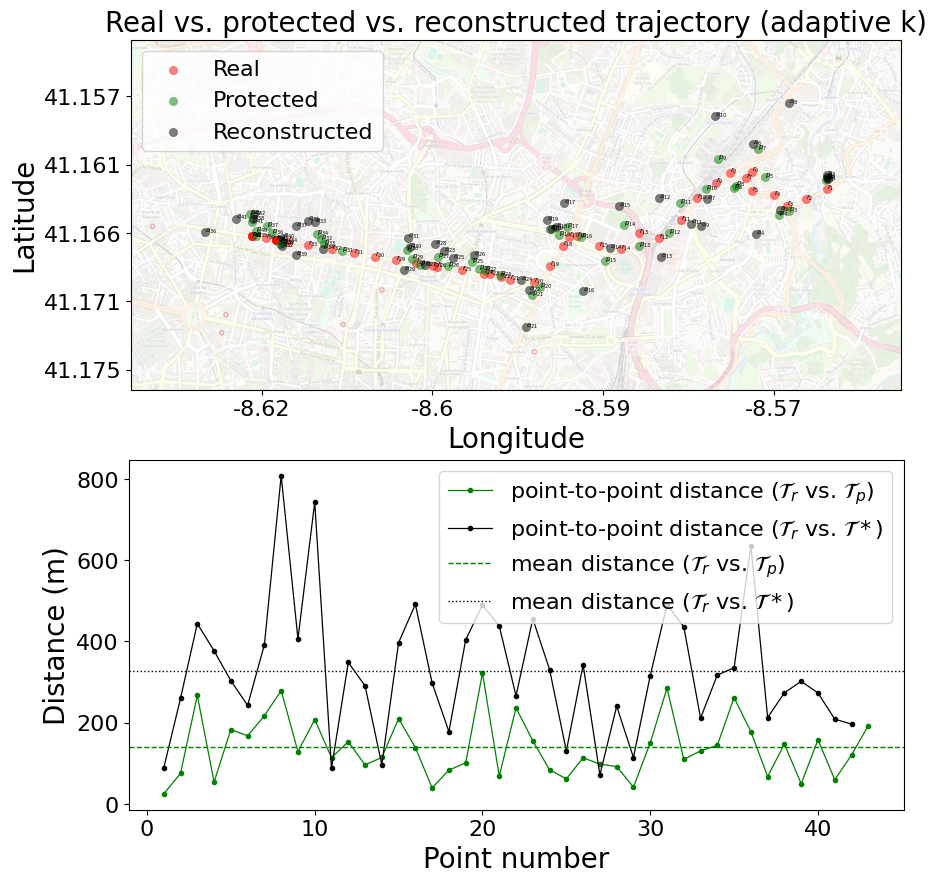

Point-to-point distance between the real and protected trajectory:
[np.float64(25.130232387984588), np.float64(75.4270991457569), np.float64(267.22581499609856), np.float64(54.18164240493658), np.float64(183.182861821388), np.float64(167.92173132509558), np.float64(217.22794221050245), np.float64(279.32334301320293), np.float64(128.85082150458493), np.float64(208.0179006410887), np.float64(114.15855516418577), np.float64(153.4015433734572), np.float64(96.48181669084073), np.float64(114.62047284471343), np.float64(210.29526429155948), np.float64(138.7800107739463), np.float64(39.8324068391823), np.float64(83.50959938726024), np.float64(101.44426665527268), np.float64(322.6099416875031), np.float64(68.57161606375368), np.float64(236.64677152991547), np.float64(155.66543381749366), np.float64(84.1144761483195), np.float64(62.026199916338804), np.float64(113.765543091173), np.float64(98.20110770687643), np.float64(92.18100547380733), np.float64(41.665021533752764), np.float64(150.291913052

<Figure size 640x480 with 0 Axes>

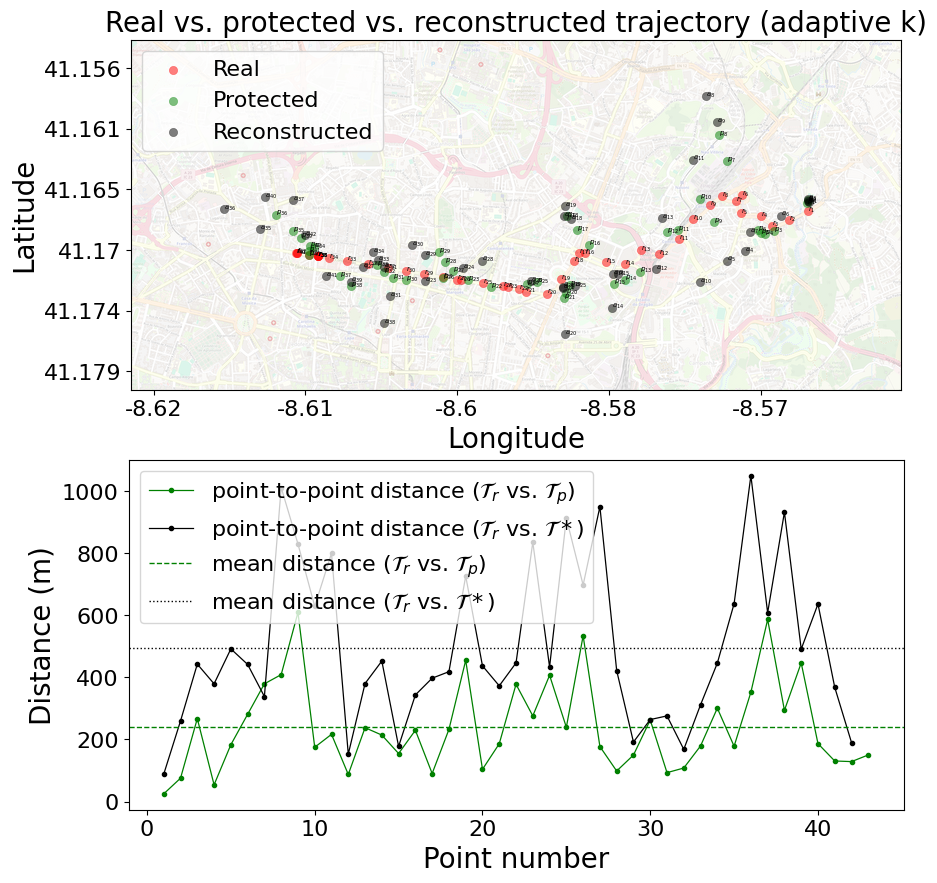

Point-to-point distance between the real and protected trajectory:
[np.float64(25.130232387984588), np.float64(75.4270991457569), np.float64(267.22581499609856), np.float64(54.18164240493658), np.float64(183.182861821388), np.float64(281.05576779963934), np.float64(379.23928683740905), np.float64(408.8108420865557), np.float64(608.815060285994), np.float64(174.9602259217465), np.float64(216.6241595916468), np.float64(87.46619268752593), np.float64(237.99512163809314), np.float64(214.24701677465217), np.float64(154.8332501711607), np.float64(229.7101682781408), np.float64(90.46035689385543), np.float64(232.3638007828584), np.float64(454.89897248408937), np.float64(104.06152844305952), np.float64(186.28708302262945), np.float64(377.66773969604805), np.float64(276.0488860210421), np.float64(406.65233657689134), np.float64(239.3626666594906), np.float64(533.9416869614162), np.float64(177.29812110845538), np.float64(98.55562999716953), np.float64(149.8653009106747), np.float64(262.814050749

<Figure size 640x480 with 0 Axes>

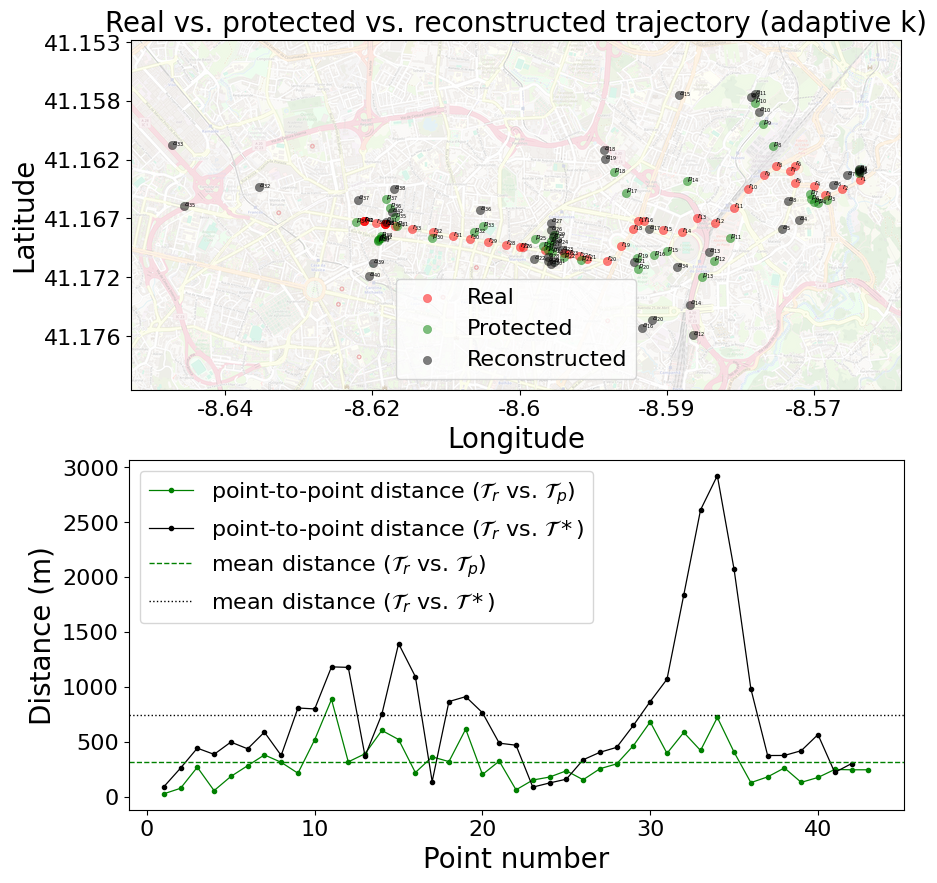

Point-to-point distance between the real and protected trajectory:
[np.float64(25.130232387984588), np.float64(75.4270991457569), np.float64(267.22581499609856), np.float64(54.18164240493658), np.float64(183.182861821388), np.float64(281.05576779963934), np.float64(379.23928683740905), np.float64(312.00931879415236), np.float64(212.3188343966434), np.float64(518.2583464902907), np.float64(884.5065091638533), np.float64(315.9408781231943), np.float64(389.86265363364504), np.float64(602.1708266442821), np.float64(519.2896233362806), np.float64(218.6040035153052), np.float64(361.809381490859), np.float64(318.3755461660818), np.float64(613.915200482775), np.float64(200.96333994125624), np.float64(322.6551820393525), np.float64(61.255151567524706), np.float64(150.55684815905758), np.float64(177.61904787377858), np.float64(234.59428223045205), np.float64(153.1953316379462), np.float64(253.2863227147337), np.float64(297.78615026092956), np.float64(464.1651655121154), np.float64(679.5042895966

<Figure size 640x480 with 0 Axes>

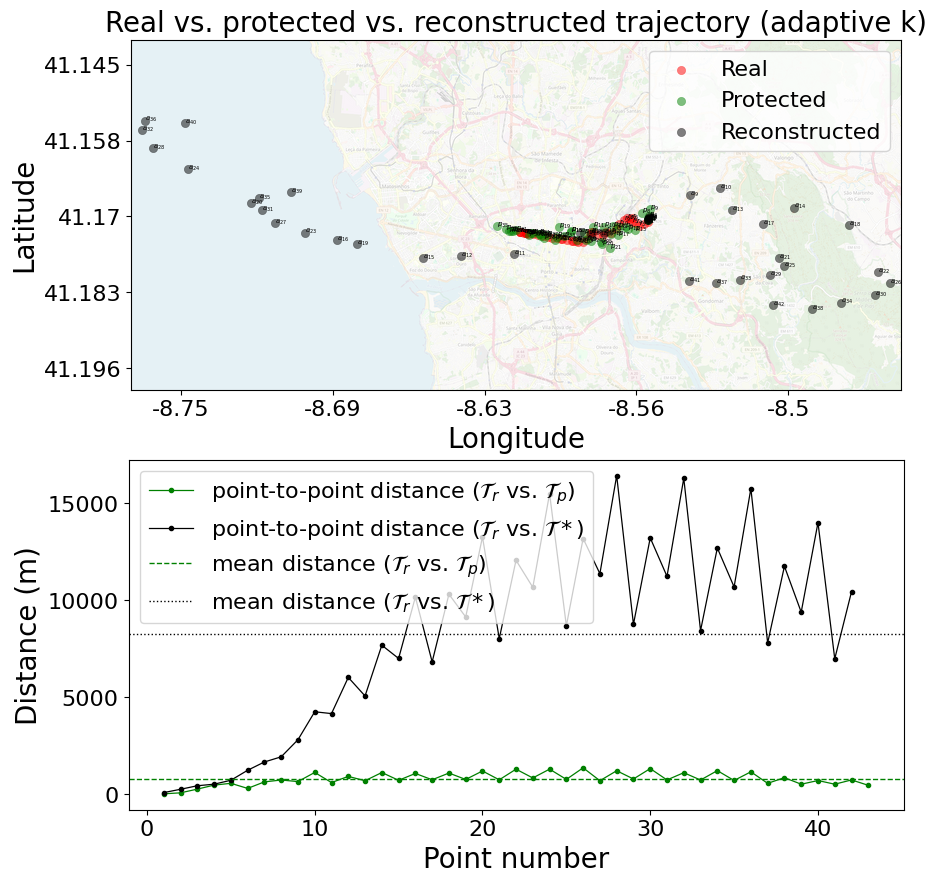

Point-to-point distance between the real and protected trajectory:
[np.float64(25.130232387984588), np.float64(75.4270991457569), np.float64(267.22581499609856), np.float64(473.0903445972461), np.float64(566.1975330301765), np.float64(304.17925182498846), np.float64(640.1293360404374), np.float64(735.773822893797), np.float64(655.8599751906128), np.float64(1126.1783166979505), np.float64(605.2914245432189), np.float64(922.5072011767525), np.float64(699.7841983101786), np.float64(1122.3793812495087), np.float64(721.9239693449094), np.float64(1073.782382648995), np.float64(749.1951126634025), np.float64(1094.8470331979693), np.float64(765.0310229309733), np.float64(1201.915683227588), np.float64(746.8644093103786), np.float64(1295.2332315192527), np.float64(842.3090635286051), np.float64(1296.8181308807918), np.float64(768.2319144336878), np.float64(1365.0498647853285), np.float64(700.42446358604), np.float64(1214.3213325664142), np.float64(789.8435913195628), np.float64(1324.89633001320

In [11]:
# Select a trajectory to visualize
traj_idx = 5

n_trajs = 10

# Load the data and plot trajectory with id=traj_idx
Y_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_test_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")
test_seq_len = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_test_seq_len_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")

for mmin, mmax in zip(mean_min, mean_max):
        
    normalization_ranges = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_normalization_ranges_test.pkl") # the scaler used to normalize the data
    
    normalization_ranges = {"min": normalization_ranges["min"][0:2], "max": normalization_ranges["max"][0:2]}
    
    Y_test_dn = denormalize_data(dataset = copy.deepcopy(Y_test), normalization_ranges = normalization_ranges)
    
    Y_pred_k = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_pred_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    # Denormalize the data using the scaler or normalization ranges
    Y_pred_k_dn = denormalize_data(dataset = Y_pred_k, normalization_ranges = normalization_ranges) 
    
    Y_reconstructed_k = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_reconstructed_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    Y_reconstructed_k = Y_reconstructed_k[0]
    
    Y_reconstructed_k_dn = denormalize_data(dataset = Y_reconstructed_k, normalization_ranges = normalization_ranges) 
    
    dists_k = compute_point_to_point_haversine_distances(Y_test_dn[traj_idx][0:test_seq_len[traj_idx]], Y_pred_k_dn[traj_idx])
    
    dists_k_reconstructed = compute_point_to_point_haversine_distances(Y_test_dn[traj_idx][1:test_seq_len[traj_idx]], Y_reconstructed_k_dn[traj_idx])

    plot_trajectory_map_attack(actual_norm = Y_test_dn[traj_idx][1:test_seq_len[traj_idx]],
                        predicted_norm  = Y_pred_k_dn[traj_idx][1:test_seq_len[traj_idx]],
                        attack_norm = Y_reconstructed_k_dn[traj_idx],
                        dists_p = dists_k,
                        dists_a = dists_k_reconstructed,
                        dist_min = mmin,
                        dist_max = mmax,
                        aspect_ratio = 2.2,
                        adaptive = True,
                        traj_id = traj_idx,
                        scatter = True,
                        savePath = DATA_FOLDER + selected_dataset.lower() + "_reconstructed_mean_min" + str(mmin) + "_mean_max" + str(mmax) + "_trajid_" + str(traj_idx))
    print("Point-to-point distance between the real and protected trajectory:")
    print (dists_k)
    print("##################################")
    print("Targeted mean: ")
    print("Mean min: " + str(mmin) + " / Mean max: " + str(mmax))
    print("Mean distance between the real and protected trajectory:")
    print(np.mean(dists_k))
    print("Mean distance between the real and reconstructed trajectory:")
    print(np.mean(dists_k_reconstructed))
    print("##################################")

## **Experiments (SanFrancisco dataset)**

In [15]:
selected_dataset = "SANFRANCISCO"
# The mde_k distances are computed in the trajgen-fixed-k.py script
# They represent the MDE for k=1, k=2, k=3, and k=4 (computed for 5000 trajectories)
# These values are used to determine the adaptive k values based on the privacy and utility constraints
mde_k = [168, 286, 489, 824] # mean distances for k=1, k=2, k=3, and k=4

mean_min = [170, 250, 350] # privacy contraint
mean_max = [350, 450, 550] # utility contraint

#### **Load Model and Test Data** 

In [16]:
# Load the test data 
X_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_X_test.pkl") # the input trajectory data
Y_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_test.pkl") # the test trajectory data
test_seq_len = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_seq_len_test.pkl") # the sequence lenght of the input trajectory data
normalization_ranges = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_normalization_ranges_test.pkl") # the scaler used to normalize the data

normalization_ranges = {"min": normalization_ranges["min"][0:2], "max": normalization_ranges["max"][0:2]}

# Save the model
mdl = load_pickle( MODEL_FOLDER + "mdlgru-"+selected_dataset.lower()+".pkl")

# Model for BS = 1
model_sl = create_GRU_model(GRU_cells= LSTM_CELLS,
                          seq_len = 1,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)


# Set weights and states
model_sl.set_weights(mdl.get_weights())

#### **Reconstruct trajectories** 

In [17]:
# Recontruct the trajectories from the predictions

n_trajs = 10

for mmin, mmax in zip(mean_min, mean_max):
        
    print("Processing trajectories with mean_min = " + str(mmin) + " and mean_max = " + str(mmax))
    
    normalization_ranges = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_normalization_ranges_test.pkl") # the scaler used to normalize the data
    normalization_ranges = {"min": normalization_ranges["min"][0:2], "max": normalization_ranges["max"][0:2]}
        
    for i in range(len(mde_k)):
        if mde_k[i] > mmin:
                k_min = i+1
                break
    k_max = k_min + round((mmax-mmin)/mde_k[0]) + 1

    Y_pred_k = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_pred_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    Y_pred_k = add_speed_column(Y_pred_k, time_diff_seconds=15)  # The sampling rate of 15 seconds
    
    data = []
    for arr in Y_pred_k:
        df = pd.DataFrame(arr, columns=COLUMNS_INPUT)
        data.append(df)

    # # Normalize the data using scaler or normalization ranges
    # scaler, data = normalize_trajectory_data(dataset = data, normalization_type = "min-max")
    data = min_max_normalize_third_column(data)

    num_of_traj = len(Y_pred_k)
    # # Create X and Y from the data
    X, Y =  create_X_Y_from_data(data, num_of_traj, k=1)

    # Train Data Preparation (the same format as the test data)
    X_pred_k, Y_pred_k, test_traj_seq_lengths = test_data_preparation(TRAINING_TESTING_SAME_FILE = TRAINING_TESTING_SAME_FILE,
                                                                    X = copy.deepcopy(X), Y = copy.deepcopy(Y),
                                                                    num_of_traj = num_of_traj,
                                                                    training_size = 0,
                                                                    SEQ_LEN = SEQ_LEN,
                                                                    NUM_FEATS = NUM_FEATS,
                                                                    TESTING_FILE = None,
                                                                    data = data)
    
    
    Y_reconstructed_k = apu_trajgen_adaptive_k(mdl = model_sl,
                                            X_t = copy.deepcopy(X_pred_k),
                                            test_traj_seq_lengths = test_traj_seq_lengths,
                                            SEQ_LENGTH = 1,
                                            NUM_FEATS = NUM_FEATS,
                                            su_funct = compute_su_score1,
                                            su_funct_args={"mean_min": mmin, "mean_max": mmax},
                                            normalization_ranges = normalization_ranges,
                                            k_min = k_min,
                                            k_max = k_max,
                                            save_results = False)
    
    save_pickle(Y_reconstructed_k, DATA_FOLDER + selected_dataset.lower() + "_Y_reconstructed_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")

Processing trajectories with mean_min = 170 and mean_max = 350
Processing trajectories with mean_min = 250 and mean_max = 450
Processing trajectories with mean_min = 350 and mean_max = 550


#### **Plot trajectories** 

<Figure size 640x480 with 0 Axes>

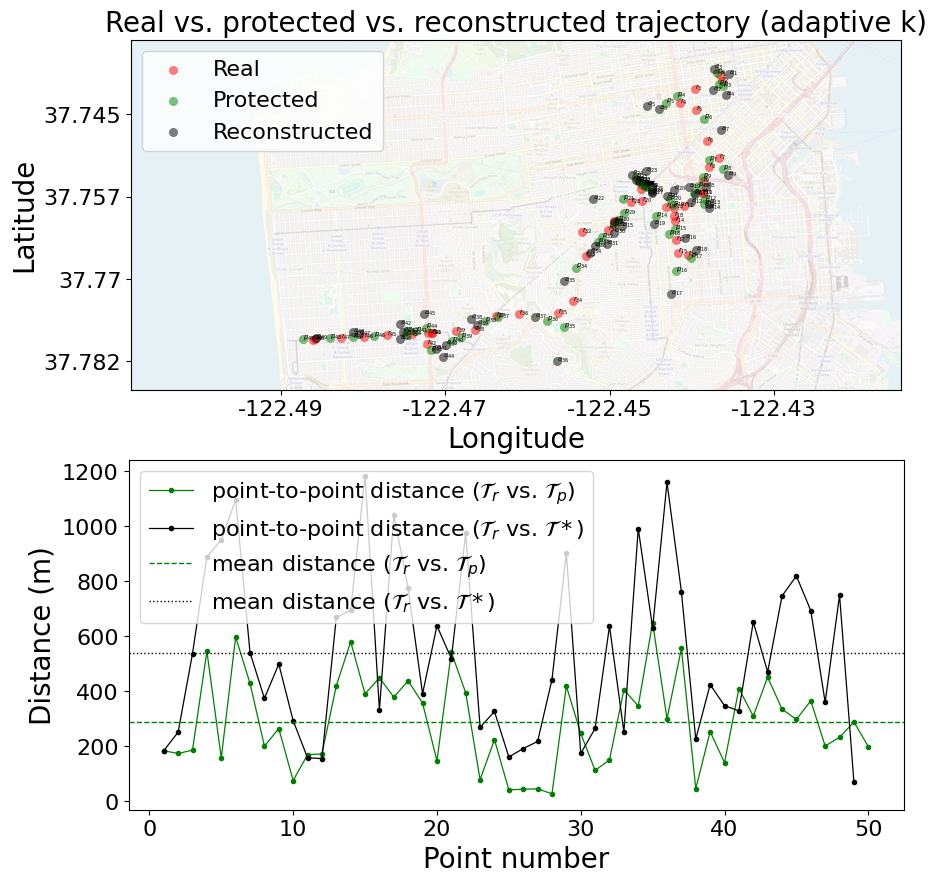

Point-to-point distance between the real and protected trajectory:
[np.float64(183.4697300621649), np.float64(173.5940229840204), np.float64(185.73906267376432), np.float64(545.4402993504735), np.float64(157.23698308847986), np.float64(597.0910328303878), np.float64(428.6918044052749), np.float64(200.21023103543467), np.float64(264.0545922056001), np.float64(75.1635664740932), np.float64(169.1192680561065), np.float64(171.920262514807), np.float64(419.9157293691668), np.float64(580.1450679324116), np.float64(390.2210879434966), np.float64(448.60764275392904), np.float64(378.88883757706924), np.float64(437.59779662204943), np.float64(356.7425447054248), np.float64(146.93204956016024), np.float64(542.0533508202889), np.float64(394.2226990108626), np.float64(78.35162769746715), np.float64(224.0455181540555), np.float64(41.32073562972907), np.float64(43.49525237016922), np.float64(44.89126928317948), np.float64(26.85311127904457), np.float64(418.53203693749816), np.float64(246.515146780887

<Figure size 640x480 with 0 Axes>

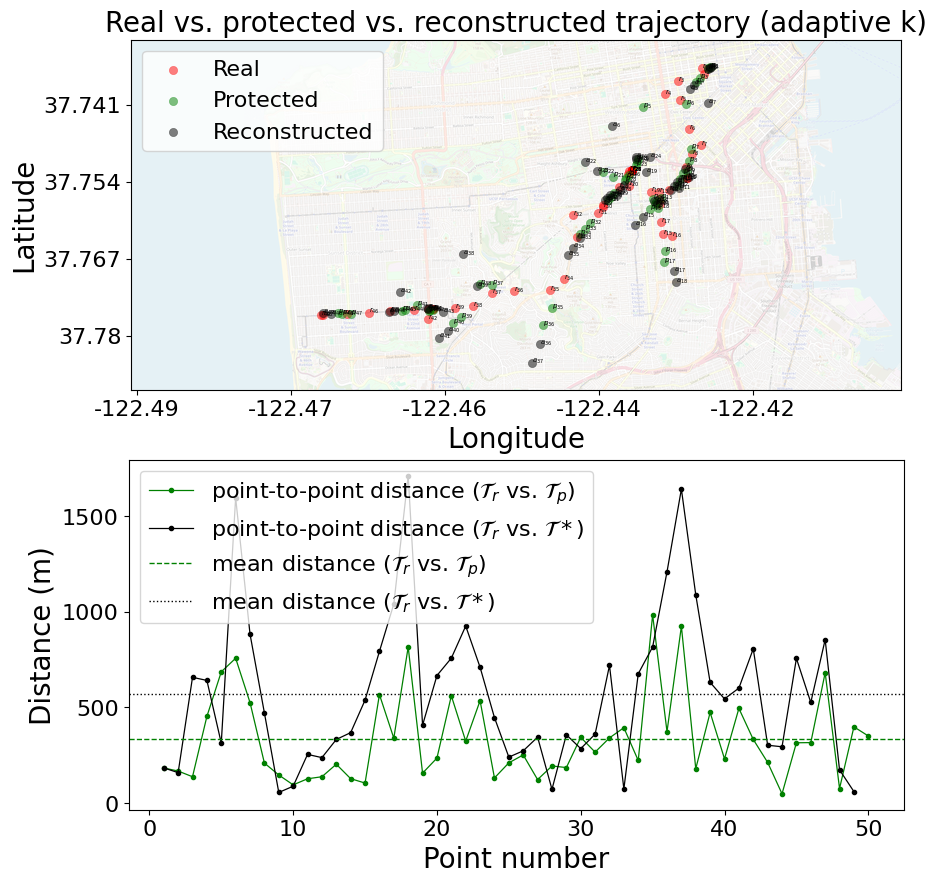

Point-to-point distance between the real and protected trajectory:
[np.float64(183.4697300621649), np.float64(167.54387268993054), np.float64(137.65065111774706), np.float64(453.0845150497728), np.float64(686.4533362333126), np.float64(757.4649033320696), np.float64(525.5739783376157), np.float64(209.15845833250938), np.float64(146.82271593714492), np.float64(95.19284021044076), np.float64(126.98357427245607), np.float64(137.68716109585887), np.float64(203.04628795751444), np.float64(127.46432071609117), np.float64(104.68138995194876), np.float64(567.521911579616), np.float64(339.3821626587137), np.float64(816.5748184510616), np.float64(156.57019766313556), np.float64(235.30173052926554), np.float64(561.1742052901002), np.float64(324.0773599161525), np.float64(535.5224123368934), np.float64(131.3925443433088), np.float64(210.33617495142843), np.float64(251.80406570557525), np.float64(122.73641508743881), np.float64(193.96316082291784), np.float64(185.69738564598111), np.float64(343.854

<Figure size 640x480 with 0 Axes>

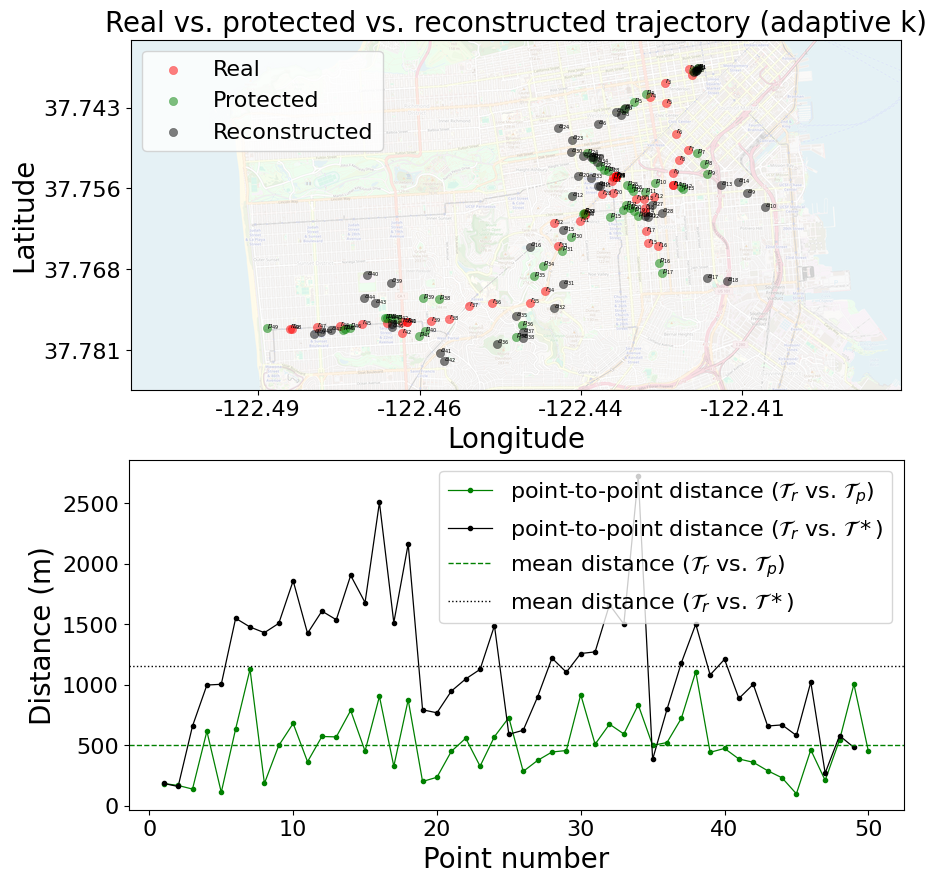

Point-to-point distance between the real and protected trajectory:
[np.float64(183.4697300621649), np.float64(167.54387268993054), np.float64(137.65065111774706), np.float64(614.986785938957), np.float64(110.64059699246724), np.float64(634.7715000882351), np.float64(1127.3131738508416), np.float64(184.4734043417954), np.float64(497.64301925829193), np.float64(679.4496034291913), np.float64(363.3724110452106), np.float64(572.0796365646379), np.float64(568.5083326244564), np.float64(787.0541489043625), np.float64(451.33763897959005), np.float64(902.9346375758886), np.float64(326.0025878956999), np.float64(874.3969843115549), np.float64(200.4017584366158), np.float64(235.1557332960762), np.float64(449.09680772426293), np.float64(557.679682983459), np.float64(326.7075443652944), np.float64(570.6555292704592), np.float64(728.2050098316089), np.float64(283.297484169645), np.float64(374.3166237072923), np.float64(443.6757818733347), np.float64(456.0514207186794), np.float64(917.5545971233906)

In [18]:
# Select a trajectory to visualize
traj_idx = 5

n_trajs = 10

# Load the data and plot trajectory with id=traj_idx
Y_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_test_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")
test_seq_len = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_test_seq_len_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")

for mmin, mmax in zip(mean_min, mean_max):
        
    normalization_ranges = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_normalization_ranges_test.pkl") # the scaler used to normalize the data
    
    normalization_ranges = {"min": normalization_ranges["min"][0:2], "max": normalization_ranges["max"][0:2]}
    
    Y_test_dn = denormalize_data(dataset = copy.deepcopy(Y_test), normalization_ranges = normalization_ranges)
    
    Y_pred_k = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_pred_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    # Denormalize the data using the scaler or normalization ranges
    Y_pred_k_dn = denormalize_data(dataset = Y_pred_k, normalization_ranges = normalization_ranges) 
    
    Y_reconstructed_k = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_reconstructed_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    Y_reconstructed_k = Y_reconstructed_k[0]
    
    Y_reconstructed_k_dn = denormalize_data(dataset = Y_reconstructed_k, normalization_ranges = normalization_ranges) 
    
    dists_k = compute_point_to_point_haversine_distances(Y_test_dn[traj_idx][0:test_seq_len[traj_idx]], Y_pred_k_dn[traj_idx])
    
    dists_k_reconstructed = compute_point_to_point_haversine_distances(Y_test_dn[traj_idx][1:test_seq_len[traj_idx]], Y_reconstructed_k_dn[traj_idx])

    plot_trajectory_map_attack(actual_norm = Y_test_dn[traj_idx][1:test_seq_len[traj_idx]],
                        predicted_norm  = Y_pred_k_dn[traj_idx][1:test_seq_len[traj_idx]],
                        attack_norm = Y_reconstructed_k_dn[traj_idx],
                        dists_p = dists_k,
                        dists_a = dists_k_reconstructed,
                        dist_min = mmin,
                        dist_max = mmax,
                        aspect_ratio = 2.2,
                        adaptive = True,
                        traj_id = traj_idx,
                        scatter = True,
                        savePath = DATA_FOLDER + selected_dataset.lower() + "_reconstructed_mean_min" + str(mmin) + "_mean_max" + str(mmax) + "_trajid_" + str(traj_idx))
    print("Point-to-point distance between the real and protected trajectory:")
    print (dists_k)
    print("##################################")
    print("Targeted mean: ")
    print("Mean min: " + str(mmin) + " / Mean max: " + str(mmax))
    print("Mean distance between the real and protected trajectory:")
    print(np.mean(dists_k))
    print("Mean distance between the real and reconstructed trajectory:")
    print(np.mean(dists_k_reconstructed))
    print("##################################")